# Data Analysis of Interest Rates

This notebook shows a basic data analysis of the interest rate series. It starts by simple plotting the series and then
analyses its structure.

## Plotting Interest rates

First, we look at the interest rates and the cumulative sum.

In [15]:
train_start = '2018-10-01 00:00:00'
train_end = '2020-01-01 00:00:00'

In [16]:
import pandas as pd
import numpy as np
import cufflinks as cf

cf.go_offline()

df = pd.read_csv('../data/interest_rates_p1.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

df['cum_interest_rate'] = df['interest_rate'].cumsum()

In [17]:
df['train_interest_rate'] = df['interest_rate']
df['test_interest_rate'] = df['interest_rate']
df.loc[df.index >= pd.to_datetime(train_end), 'train_interest_rate'] = np.nan
df.loc[df.index < pd.to_datetime(train_end), 'test_interest_rate'] = np.nan
fig = df[['train_interest_rate', 'test_interest_rate']].iplot(title='Interest rate history',
                                                              yaxis_title='Interest rate in %', asFigure=True)
fig.update_layout(yaxis=dict(tickformat=".2%"))
fig

In [18]:
df['cum_train_interest_rate'] = df['cum_interest_rate']
df['cum_test_interest_rate'] = df['cum_interest_rate']
df.loc[df.index >= pd.to_datetime(train_end), 'cum_train_interest_rate'] = np.nan
df.loc[df.index < pd.to_datetime(train_end), 'cum_test_interest_rate'] = np.nan
fig = df[['cum_train_interest_rate', 'cum_test_interest_rate']].iplot(title='Cumulative Interest rate history',
                                                                      yaxis_title='Interest rate in %', asFigure=True)
fig.update_layout(yaxis=dict(tickformat=".2%"))
fig

Looking at the cumulative interest rates yields a return of 5 % by simple being long all the time.

## Modelling
Assuming that the interest rates series is stationary (for simplicity it is not shown that it is) we can use the partial
autocorrelation for determining the number of lags for predicting the next interest rate. This will give us a better
understanding of the underlying series process.

In [19]:
# separate data into training and test subsets
train_df = df[df.index < pd.to_datetime(train_end)]
test_df = df[df.index >= pd.to_datetime(train_end)]

## Partial Autocorrelation
Partial Autocorrelation is used to determine the number of significant lags (if modelled linearly) for predicting the
next interest rate. (More details can be found under "Auto Regressive Models") This gives us a better understanding of
needed interest rates used as input. However, this does not have to be the optimal number of lags for determining the
trading action.

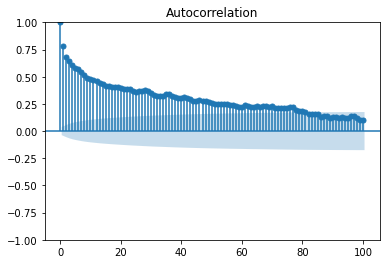

/opt/homebrew/anaconda3/envs/rl-finance-private/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



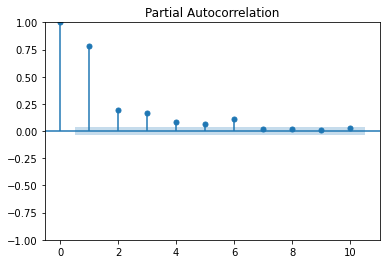

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt

plot_acf(train_df['interest_rate'], lags=100)
plt.show()

plot_pacf(train_df['interest_rate'], lags=10)
plt.show()


The Partial Autocorrelation shows us that the number of significant lags (if modelled linearly) is 6.

## Linear Regression
In this section we will model the interest rate history as an Auto Regressive model. This will give us some initial
weights for our neural network.

In [21]:
shifts = 6

for shift in range(shifts):
    # normalize interest rate and shift it
    df[f'interest_rate_{shift}'] = (df['interest_rate'].shift(shift) - 0.002) / 0.002 + 1

df['next_interest_rate'] = df['interest_rate_0'].shift(-1)

train_df = df[df.index < pd.to_datetime(train_end)]
test_df = df[df.index >= pd.to_datetime(train_end)]
train_df

,interest_rate,cum_interest_rate,train_interest_rate,test_interest_rate,cum_train_interest_rate,cum_test_interest_rate,interest_rate_0,interest_rate_1,interest_rate_2,interest_rate_3,interest_rate_4,interest_rate_5,next_interest_rate
timestamp,,,,,,,,,,,,,
2018-10-01 00:00:00,-0.000061,-0.000061,-0.000061,NaN,-0.000061,NaN,-0.030646,NaN,NaN,NaN,NaN,NaN,0.015315
2018-10-01 04:00:00,0.000031,-0.000031,0.000031,NaN,-0.000031,NaN,0.015315,-0.030646,NaN,NaN,NaN,NaN,-0.025493
2018-10-01 08:00:00,-0.000051,-0.000082,-0.000051,NaN,-0.000082,NaN,-0.025493,0.015315,-0.030646,NaN,NaN,NaN,-0.017925
2018-10-01 12:00:00,-0.000036,-0.000117,-0.000036,NaN,-0.000117,NaN,-0.017925,-0.025493,0.015315,-0.030646,NaN,NaN,-0.007737
2018-10-01 16:00:00,-0.000015,-0.000133,-0.000015,NaN,-0.000133,NaN,-0.007737,-0.017925,-0.025493,0.015315,-0.030646,NaN,0.032751
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 04:00:00,0.000239,0.057567,0.000239,NaN,0.057567,NaN,0.119707,0.176392,0.198102,0.088239,0.109109,0.115989,0.118422
2019-12-31 08:00:00,0.000237,0.057804,0.000237,NaN,0.057804,NaN,0.118422,0.119707,0.176392,0.198102,0.088239,0.109109,0.017156
2019-12-31 12:00:00,0.000034,0.057838,0.000034,NaN,0.057838,NaN,0.017156,0.118422,0.119707,0.176392,0.198102,0.088239,0.077258


In [22]:

from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False)
ranged = train_df[[f'interest_rate_{shift}' for shift in range(shifts)] + ['next_interest_rate']].dropna()
lr.fit(ranged[[f'interest_rate_{shift}' for shift in range(shifts)]], ranged['next_interest_rate'])
pd.Series(lr.coef_).iplot(kind='bar',
                          title='Coefficients Interest rate prediction, Training',
                          yaxis_title='Coefficients in decimal',
                          xaxis_title='Lags Interest Rate')
print(f"Training Coefficients: {lr.coef_}")

lr = LinearRegression(fit_intercept=False)
ranged = test_df[[f'interest_rate_{shift}' for shift in range(shifts)] + ['next_interest_rate']].dropna()
lr.fit(ranged[[f'interest_rate_{shift}' for shift in range(shifts)]], ranged['next_interest_rate'])
pd.Series(lr.coef_).iplot(kind='bar',
                          title='Coefficients Interest rate prediction, Test',
                          yaxis_title='Coefficients in decimal',
                          xaxis_title='Lags Interest Rate')
print(f"Test Coefficients: {lr.coef_}")

Training Coefficients: [0.56419391 0.07126294 0.09984709 0.04255326 0.00321324 0.10752261]


Test Coefficients: [ 0.58984631  0.16842767  0.00972863  0.10853518  0.03402437 -0.02298076]
